# CCM counter example regression 2

CCM res > CCM EYE >= STD

In [1]:
import sys
import numpy as np
from graphviz import Digraph, Source
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sympy import Matrix, simplify, symbols
from sympy.solvers.solveset import linsolve

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.flow import Graph, Node, sample_graph
from lib.data import SubColumn
from lib.models import MLP, CCM_res, SubColumnNet
from lib.train import train_step_standard, train_step_xyc, train
from lib.regularization import EYE
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap

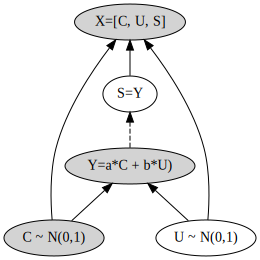

In [60]:
dot = Digraph()

dot.node('Y', 'Y=a*C + b*U)', style='filled', fillcolor='lightgray')
dot.node('C', 'C ~ N(0,1)', style='filled', fillcolor='lightgray')
dot.node('U', 'U ~ N(0,1)')
dot.node('S', 'S=Y')
dot.node('X', 'X=[C, U, S]', style='filled', fillcolor='lightgray')

dot.edges(['UY', 'CY', 'UX', 'CX', 'SX'])
dot.edge('Y', 'S', style='dashed')

dot.graph_attr['rankdir'] = 'BT'
dot.render('figures/counter_example2')
dot

This case is interesting b/c the problem is linear and C for sure is relevant for predicting Y.

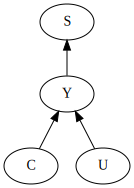

          C         U          S          Y
0 -0.042903 -0.524272  -5.671754  -5.671754
1  2.319594 -0.065565  22.540288  22.540288
2  0.774285 -2.189277 -14.149917 -14.149917
3  0.123952  0.655972   7.799235   7.799235
4  0.747272 -0.868043  -1.207712  -1.207712
5  0.722365  0.038700   7.610642   7.610642
6 -0.192091 -1.102478 -12.945689 -12.945689
7 -0.414094 -1.197031 -16.111254 -16.111254
8  0.078517 -0.005214   0.733031   0.733031
9  1.278471  1.447863  27.263337  27.263337


,C,U,S,Y
0,-0.159554,1.008511,0.0,8.489574
1,1.101341,0.818393,0.0,19.197337
2,-1.096081,-1.152956,0.0,-22.490374
3,0.155856,-0.370490,0.0,-2.146339
4,0.299497,0.442638,0.0,7.421345
5,0.260135,-1.041198,0.0,-7.810626
6,1.513302,-0.293792,0.0,12.195097
7,0.462401,0.278342,0.0,7.407432
8,-0.943916,1.760664,0.0,8.167481
9,0.140288,0.859657,0.0,9.999448


In [34]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    c = Node('C')
    u = Node('U')
    y  = Node('Y', lambda c, u: 10*(c+u),
              [c, u])    
    s = Node('S', lambda y: y, [y])
    
    # initialize the values from data
    graph = Graph([c, u, s, y])   
    return graph

graph = build_graph() # the causal graph
graph.draw()
n = 10
print(sample_graph(graph, {'C': np.random.randn(n), 'U': np.random.randn(n)})[['C', 'U', 'S', 'Y']])
sample_graph(graph, {'C': np.random.randn(n), 'U': np.random.randn(n), 'S': np.zeros(n)})[['C', 'U', 'S', 'Y']]

In [35]:
n = 100000
bs = 100
wd = 1e-4


XYC = sample_graph(graph, {'C': np.random.randn(n), 'U': np.random.randn(n)})[['C', 'U', 'S', 'Y']]
XYC_te = sample_graph(graph, {'C': np.random.randn(n), 'U': np.random.randn(n)})[['C', 'U', 'S', 'Y']]
XYC_deploy = sample_graph(graph, {'C': np.random.randn(n), 'U': np.random.randn(n), 'S': np.zeros(n)})[['C', 'U', 'S', 'Y']]

def get_X_Y_C(XYC):
    X = np.array(XYC[['C', 'U', 'S']])
    Y = np.array(XYC[['Y']])
    C = np.array(XYC[['C']])
    return torch.from_numpy(X).float(), torch.from_numpy(Y).float(), torch.from_numpy(C).float()

X, Y, C = get_X_Y_C(XYC)
d = X.shape[1]
X_te, Y_te, C_te = get_X_Y_C(XYC_te)
X_de, Y_de, C_de = get_X_Y_C(XYC_deploy)
r = torch.zeros(d) # concept mask
r[0] = 1

# accuracy
mse_criterion = lambda o, y: F.mse_loss(o, y)

# dataset
loader_xy = DataLoader(TensorDataset(X, Y), batch_size=bs, shuffle=True) # regular dataset
loader_xy_te = DataLoader(TensorDataset(X_te, Y_te), batch_size=bs, shuffle=False) # regular dataset
loader_xy_de = DataLoader(TensorDataset(X_de, Y_de), batch_size=bs, shuffle=False) # regular dataset

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 651.00it/s]


epoch   0: loss 2.088e+02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 699.52it/s]


epoch   1: loss 2.358e+01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 646.56it/s]


epoch   2: loss 7.189e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 704.25it/s]


epoch   3: loss 1.378e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 733.23it/s]


epoch   4: loss 4.323e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 601.02it/s]


epoch   5: loss 8.593e-04


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 755.62it/s]


epoch   6: loss 6.479e-05


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 770.01it/s]


epoch   7: loss 1.050e-06


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 890.01it/s]


epoch   8: loss 1.495e-09


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 936.38it/s]


epoch   9: loss 7.635e-11


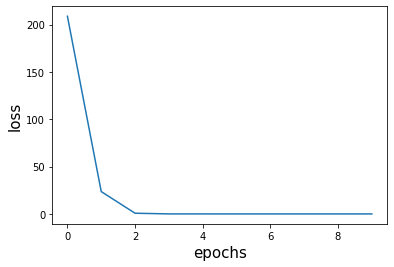

In [36]:
def standard_model(loader_xy, d, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    # regular model
    net = MLP([d, 1])
    
    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=nn.MSELoss())
    if plot: plot_log(log)
    return net

n_epochs = 10
STD = standard_model(loader_xy, d, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [37]:
# ['C', 'U', 'S']
list(STD.classifier[0].parameters())

[Parameter containing:
 tensor([[0.9833, 0.9833, 0.9017]], requires_grad=True),
 Parameter containing:
 tensor([1.9091e-07], requires_grad=True)]

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 599.01it/s]


epoch   0: loss 4.733e+01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 642.84it/s]


epoch   1: loss 6.458e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 744.09it/s]


epoch   2: loss 8.066e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 664.34it/s]


epoch   3: loss 7.511e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 639.39it/s]


epoch   4: loss 7.411e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 603.49it/s]


epoch   5: loss 7.395e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 603.32it/s]


epoch   6: loss 7.385e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 688.77it/s]


epoch   7: loss 7.368e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 543.36it/s]


epoch   8: loss 7.341e-03


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 526.65it/s]


epoch   9: loss 7.296e-03


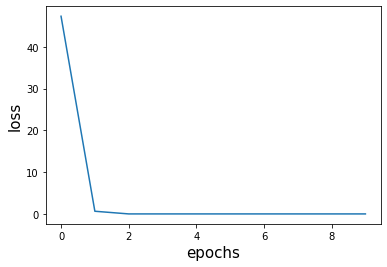

In [40]:
def CCM(loader_xy, r, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    # regular model
    net = MLP([len(r), 1])

    # train
    # criterion = lambda o_y, y: F.mse_loss(o_y, y) + 0.01 * (net.classifier[0].weight[1] - net.classifier[0].weight[0])[1:].abs().sum()
    criterion = lambda o_y, y: F.mse_loss(o_y, y) + 0.0009 * EYE(r, net.classifier[0].weight[0][1:].abs().sum())
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=criterion)
    if plot: plot_log(log)
    return net

n_epochs = 10
ccm = CCM(loader_xy, r, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [42]:
# ['C', 'U', 'S']
list(ccm.classifier[0].parameters())

[Parameter containing:
 tensor([[1.0077, 1.0058, 0.8993]], requires_grad=True),
 Parameter containing:
 tensor([-5.1957e-05], requires_grad=True)]

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 766.81it/s]


epoch   2: loss 1.607e+02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 807.93it/s]


epoch   5: loss 1.271e+02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 669.20it/s]


epoch   8: loss 1.082e+02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 705.83it/s]


epoch  11: loss 1.013e+02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 831.94it/s]


epoch  14: loss 1.004e+02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 637.71it/s]


epoch  17: loss 1.004e+02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 870.02it/s]


epoch  20: loss 1.004e+02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 886.46it/s]


epoch  23: loss 1.004e+02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 637.29it/s]


epoch  26: loss 1.004e+02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 680.77it/s]


epoch  29: loss 1.004e+02


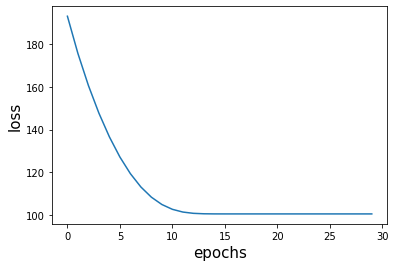

In [46]:
def CBM(loader_xy, r, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    net = nn.Sequential(SubColumnNet(r.bool()), MLP([int(sum(r).item()), 1]))

    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=nn.MSELoss())
    if plot: plot_log(log)
    return net

n_epochs = 30
cbm = CBM(loader_xy, r, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [47]:
list(cbm[1].classifier[0].parameters())

[Parameter containing:
 tensor([[10.0022]], requires_grad=True),
 Parameter containing:
 tensor([0.0926], requires_grad=True)]

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 614.79it/s]


epoch   1: loss 3.097e+01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 584.65it/s]


epoch   3: loss 1.082e+01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 619.33it/s]


epoch   5: loss 2.091e+00


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 650.54it/s]


epoch   7: loss 8.359e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 605.78it/s]


epoch   9: loss 4.328e-05


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 579.86it/s]


epoch  11: loss 1.265e-07


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 774.23it/s]


epoch  13: loss 1.268e-07


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 720.02it/s]


epoch  15: loss 1.295e-07


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 603.97it/s]


epoch  17: loss 1.423e-07


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 741.41it/s]


epoch  19: loss 3.914e-07


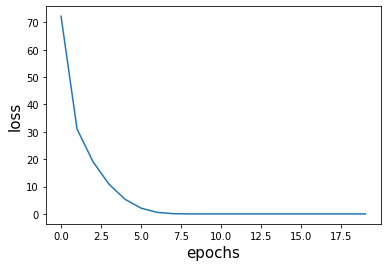

In [56]:
def Res(loader_xy, cbm, d, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    net = MLP([d, 1])    
    net = CCM_res(cbm, net)

    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    # opt = optim.SGD(net.parameters(), lr=0.01, weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=nn.MSELoss())
    if plot: plot_log(log)
    return net

n_epochs = 20
res = Res(loader_xy, cbm, d, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [57]:
list(res.net2.classifier[0].parameters())

[Parameter containing:
 tensor([[-5.5150,  4.4867,  0.5513]], requires_grad=True),
 Parameter containing:
 tensor([-0.0926], requires_grad=True)]

In [58]:
print('task mse after training: {:.1e}'.format(test(res, loader_xy_te, mse_criterion)))
print('task mse after training: {:.1e}'.format(test(ccm, loader_xy_te, mse_criterion)))
print('task mse after training: {:.1e}'.format(test(cbm, loader_xy_te, mse_criterion)))
print('task mse after training: {:.1e}'.format(test(STD, loader_xy_te, mse_criterion)))

test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 842.81it/s]


task mse after training: 2.5e-07


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1053.92it/s]


task mse after training: 2.0e-06


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1253.92it/s]


task mse after training: 1.0e+02


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 959.90it/s]

task mse after training: 5.2e-11


In [59]:
print('task mse after training: {:.1e}'.format(test(res, loader_xy_de, mse_criterion)))
print('task mse after training: {:.1e}'.format(test(ccm, loader_xy_de, mse_criterion)))
print('task mse after training: {:.1e}'.format(test(cbm, loader_xy_de, mse_criterion)))
print('task mse after training: {:.1e}'.format(test(STD, loader_xy_de, mse_criterion)))

test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 797.56it/s]


task mse after training: 6.1e+01


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1127.97it/s]


task mse after training: 1.6e+02


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1285.90it/s]


task mse after training: 1.0e+02


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1364.05it/s]

task mse after training: 1.6e+02


# Regression